# **Практика**

✍ Настало время попрактиковаться в оценке качества моделей.

На этот раз мы окунёмся в онлайн-маркетинг: будем пытаться предсказать совершение покупки пользователем во время его сессии на сайте некоторого интернет-магазина.

Сессия на сайте — это временной интервал, в течение которого происходит взаимодействие пользователя с сайтом. Отсчёт сессии стартует сразу после перехода на сайт и завершается сразу после его закрытия или при отсутствии активных действий в течение некоторого периода времени.

Важное замечание. Мы не будем стремиться достичь наивысшего качества предсказания совершения покупки. Наша цель — отработать навыки работы с несбалансированными данными и применение методов валидации для оценки качества моделей.

А теперь приступим. Для начала импортируем необходимые библиотеки:

In [18]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble # импорт модуля для ансамблей

plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
# Прочитаем таблицу с данными и выведем её на экран, чтобы убедиться, что чтение прошло успешно.
shoppers_data = pd.read_csv('data/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
# Посмотрим на размер таблицы:
print(shoppers_data.shape)


(12330, 18)


In [4]:
# В нашей таблице содержится информация о более чем 12 тысячах
# сессий на сайте интернет-магазина. Каждая сессия описывается 18 признаками.

# Заранее удостоверимся в отсутствии пропусков:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Ни в одном из столбцов пропусков нет.

Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию get_dummies():

In [5]:
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Теперь, когда необходимые преобразования выполнены, мы можем говорить о построении модели.

Итак, нам необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


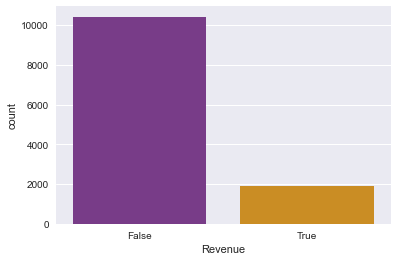

In [6]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

Из графика отчётливо видно, что мы имеем дело с несбалансированной выборкой, так как соотношение классов — 85/15, что далеко от сбалансированного соотношения 50/50.

Из 12 330 сессий покупкой товара завершаются лишь 15.47 %. Мы знаем, что такое соотношение классов заставляет нас смотреть на метрики для каждого из классов отдельно.

Условимся, что лучшей будет считаться та модель, у которой значение метрики  для пользователей, совершивших покупку, будет наибольшим.

По традиции разделим набор данных на матрицу наблюдений X и вектор ответов y:

In [7]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Давайте заранее определимся, как мы будем производить контроль качества наших моделей:

* Разделим выборку на тренировочную и тестовую.
* Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).

Итого мы будем использовать три показателя:

* значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
* значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).

Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.
***

## **ЗАДАЧИ**

Для начала позаботимся о создании отложенной тестовой выборки.

Разделите выборку на тренировочную и тестовую в соотношении 80/20. Используйте разбиение, стратифицированное по целевому признаку. В качестве значения параметра random_state возьмите число 42.

Чему равно количество сессий на сайте в тренировочной и тестовой выборках?

In [28]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print('Train:\n', len(X_train))
print('Test:\n', len(X_test))

Train:
 9864
Test:
 2466


Коллеги посоветовали нам использовать случайный лес (Random Forest) для решения данной задачи. Давайте последуем их совету.

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — F1-score.

Чему равно среднее значение метрики F1 на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

In [19]:
#Создаём модель
model = ensemble.RandomForestClassifier(
    random_state=42 #генератор случайных чисел
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

{'fit_time': array([0.59456205, 0.59470296, 0.58448267, 0.59038854, 0.58520603]),
 'score_time': array([0.02900672, 0.02800655, 0.02900696, 0.02800632, 0.0290122 ]),
 'test_score': array([0.64540338, 0.67636364, 0.65497076, 0.61904762, 0.65441176]),
 'train_score': array([1.        , 0.99959033, 1.        , 1.        , 1.        ])}

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.

Создайте список из трёх следующих моделей:

* Случайный лес из деревьев максимальной глубины 5.
* Случайный лес из деревьев максимальной глубины 7.
* Случайный лес из деревьев максимальной глубины 12.

Для всех трёх моделей количество деревьев в лесу (**n_estimators**) возьмите равным 200, количество объектов в листе (**min_samples_leaf**) — 5. Параметр random_state = 42. Остальные параметры оставьте по умолчанию.

Постройте для каждой из моделей кривую обучения.

Совет: воспользуйтесь функцией **plot_learning_curve()**, которую мы создали в юните по кривым обучения.

Для построения кривых используйте обучающий набор данных (X_train, y_train), стратифицированный кросс-валидатор на **пять** фолдов (**StratifiedKFold**) и метрику f1-score. Остальные параметры функции **learning_curve()** оставьте по умолчанию.

Из построенных кривых обучения сделайте вывод: какая глубина деревьев в лесу является оптимальной?

In [21]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

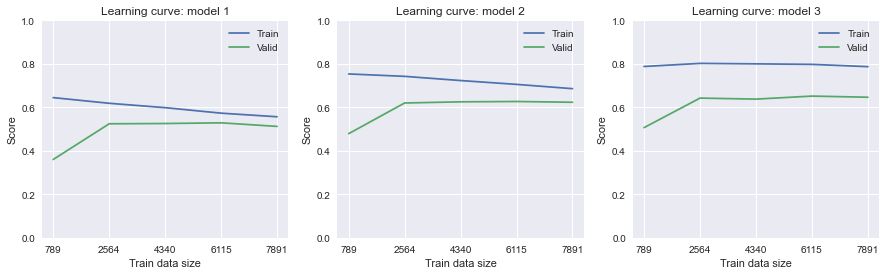

In [23]:
#Создаём список из моделей
models = [
    ensemble.RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    ),
    ensemble.RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=5,
        max_depth=7,
        random_state=42
    ),
    ensemble.RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=5,
        max_depth=12,
        random_state=42
    ),
]

#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X_train, y_train, skf, ax=axes[i], title=f'model {i+1}')

Обучите случайный лес с выбранной в предыдущем задании оптимальной глубиной на тренировочной выборке. Сделайте предсказание меток классов и выведите отчёт о метриках классификации.

Ответьте на следующие вопросы:

1. Чему равно значение метрики accuracy? Ответ округлите до двух знаков после точки-разделителя.
2. Чему равно значение метрики F1 для посетителей, завершивших сессию без покупки товара? Ответ округлите до двух знаков после точки-разделителя.
3. Чему равно значение метрики F1 для посетителей, купивших товар во время сессии? Ответ округлите до двух знаков после точки-разделителя.

In [29]:
#Создаём объект класса RandomForestClassifier
model_forest = ensemble.RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=5,
    max_depth=7,
    random_state=42
)

#Обучаем модель
model_forest.fit(X_train, y_train)

#Делаем предсказание класса train
y_pred_test = model_forest.predict(X_test)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



Попробуем повысить качество распознавания посетителей, совершивших покупку. Используем метод подбора порога вероятности с помощью PR-кривой.

Порог вероятности будем подбирать с помощью кросс-валидации.

Сделайте предсказание вероятностей принадлежности к пользователям, которые совершат покупку, на кросс-валидации на **пяти** фолдах. Используйте метод **cross_val_predict()**.

Для кросс-валидации используйте случайный лес с подобранной в задании 6.5 максимальной глубиной деревьев, набор данных (параметры X, y) — тренировочная выборка (X_train, y_train).

Постройте PR-кривую и отметьте на ней точку, в которой наблюдается максимум метрики  для посетителей, которые совершат покупку. Определите порог вероятности, соответствующий этой точке.

В качестве ответа приведите значение выбранного порога вероятности. Ответ округлите до двух знаков после точки-разделителя.

In [39]:
#Создаём объект класса RandomForestClassifier
model_forest = ensemble.RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=5,
    max_depth=7,
    random_state=42
)

#Обучаем модель
model_forest.fit(X_train, y_train)

#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model_forest, X_train, y_train, cv=skf, method='predict_proba')

y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)


Best threshold = 0.36, F1-Score = 0.69


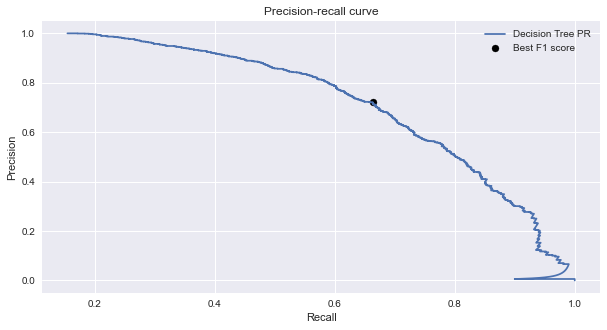

In [40]:
# Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
# Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
# Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
# Отображаем легенду
ax.legend();

Сделайте предсказание классов объекта с определённым в предыдущем задании порогом вероятности. Выведите отчёт о метриках классификации.

Ответьте на следующие вопросы:

1. Чему равно значение метрики accuracy? Ответ округлите до двух знаков после точки-разделителя.
2. Чему равно значение метрики  для посетителей, завершивших сессию без покупки товара? Ответ округлите до двух знаков после точки-разделителя.
3. Чему равно значение метрики  для посетителей, купивших товар во время сессии? Ответ округлите до двух знаков после точки-разделителя.

In [41]:
threshold_opt = 0.36
y_valid_pred_proba = model_forest.predict_proba(X_test)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_valid_pred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466

